In [1]:
# Exercise: t-SNE visualization of Amazon reviews with polarity based color-coding

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
# using the sqllite table to read data
con = sqlite3.connect(r'G:\machine_learning\Real world problem Predict rating given product reviews on Amazon\amazon\database.sqlite')

# filtering only positive and negative i.e not taking those review with score = 3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

C:\Users\hemant\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,good,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# give reviews with score>3 a postive rating and reviews with score <3 negative rating


def partition(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'
positiveNegative = filtered_data['Score']
actual =  positiveNegative.map(partition)
filtered_data['Score'] = actual


In [4]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,good,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [5]:
display  = pd.read_sql_query("""select * from Reviews where Score != 3 AND Userid = "AR5J8UI46CURR" order by ProductID """,con)

In [6]:
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
# sorting data according to product id in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis = 0,ascending =True)

In [8]:
sorted_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [9]:
# deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"},keep = 'first',inplace = False)

In [10]:
print(sorted_data.shape)

(525814, 10)


In [11]:
print(final.shape)

(364173, 10)


In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

 Text Preprocessing: Stemming, stop-word removal and Lemmatization.
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [16]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [17]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'they', 'can', 'while', 've', "that'll", "couldn't", 'needn', "she's", 'a', 'him', "you'll", 'down', 'further', "you'd", "shan't", 'ourselves', 'doing', 'if', 'before', 'then', 'ain', 'mightn', 'i', 'does', "don't", 'yours', 'between', 'couldn', 'most', 'from', 'but', 'didn', 'herself', 'hers', 'more', "didn't", 'into', 'we', "shouldn't", 'weren', "hadn't", 'having', 'being', "haven't", 'both', 'there', 'been', 'wasn', 'below', "should've", 'myself', 'and', 'those', 'have', 'under', 'o', 'had', 'only', 'than', 's', 'haven', 'will', 'itself', 'our', 'their', 'once', "isn't", 't', 'other', 'them', 'were', 'it', 'aren', 'has', 'no', 'yourselves', 'as', 'how', 'very', 'because', 'all', 'not', 'doesn', 'ours', 'y', 'with', 'such', "mustn't", "weren't", 'above', 'when', 'shouldn', 'shan', "you're", 'be', 'after', 'about', 'off', "needn't", 'up', 'me', 'mustn', "mightn't", 'of', 'that', 'now', 'll', 'her', 'so', 'd', "doesn't", 'was', 'too', 'did', 'isn', 'until', 'is', 'she', 'wouldn', 'sam

In [18]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [19]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [23]:
random_positive = final[final['Score']== 'positive'].sample(n = 1000)
random_negative = final[final['Score']== 'negative'].sample(n = 1000)


In [24]:
total_2000 = pd.concat([random_positive,random_negative])


In [25]:
#BOW
count_vect = CountVectorizer() # in scikit_learn
final_counts = count_vect.fit_transform(total_2000['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


In [26]:
print("the shape of out text BOW vectorizer",final_counts.get_shape())
print("the number of unique words",final_counts.get_shape()[1])

the shape of out text BOW vectorizer (2000, 6461)
the number of unique words 6461


(2000, 390)
<class 'numpy.ndarray'>


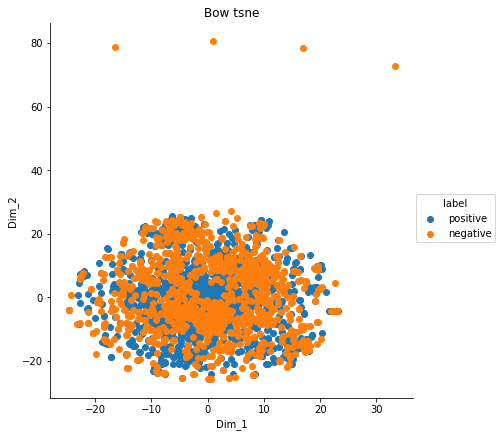

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import seaborn as sn
SC = total_2000['Score']
#Dimensionality reduction using truncated SVD
svdT = TruncatedSVD(n_components=390)
bowT = svdT.fit_transform(final_counts)

print(bowT.shape)
print(type(bowT))
# t-distributed Stochastic Neighbor Embedding.it is a tool to visualize high-dimensional data.This is T-SNE for BOW
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(bowT)

tsne_data = np.vstack((tsne_data.T,SC)).T
tsne_df = pd.DataFrame(data = tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
a = sn.FacetGrid(tsne_df, hue="label", size=6)
a.map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Bow tsne")
plt.show()


In Above Bow tsne, positive and negative data points are overlapping, so unable to classify them

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(total_2000['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 66169)
the number of unique words including both unigrams and bigrams  66169


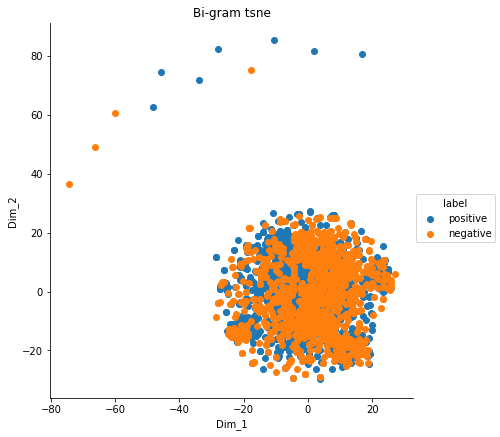

In [29]:
#Dimensionality reduction using truncated SVD
svdT = TruncatedSVD(n_components=390)
bowT = svdT.fit_transform(final_bigram_counts)
# t-distributed Stochastic Neighbor Embedding.it is a tool to visualize high-dimensional data. This is t-SNE for bi-gram
model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(bowT)

tsne_data = np.vstack((tsne_data.T,SC)).T
tsne_df = pd.DataFrame(data = tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Bi-gram tsne')
plt.show()

In Above bi -gram tsne, positive and negative data points are overlapping, so unable to classify them

In [30]:
# tf-idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(total_2000['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 66169)
the number of unique words including both unigrams and bigrams  66169


In [33]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100:110])

some sample features(unique words in the corpus) ['accept', 'accept back', 'accept chemic', 'accept complain', 'accept even', 'accept howev', 'accept marley', 'accept way', 'access', 'access car']


In [34]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

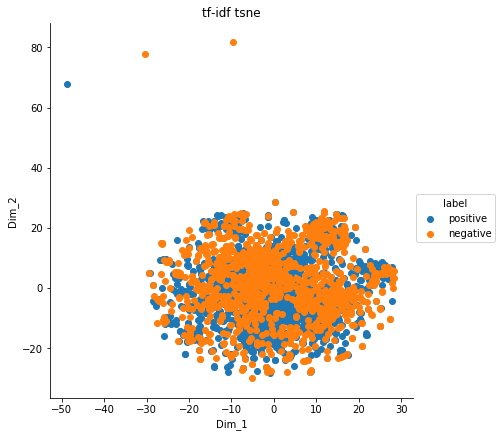

In [35]:
#Dimensionality reduction using truncated SVD
svdT = TruncatedSVD(n_components=390)
tf_idf = svdT.fit_transform(final_bigram_counts)

model = TSNE(n_components=2, random_state=0)

# t-distributed Stochastic Neighbor Embedding.it is a tool to visualize high-dimensional data. This is t-SNE for tf-idf
tsne_data = model.fit_transform(tf_idf)

tsne_data = np.vstack((tsne_data.T,SC)).T
tsne_df = pd.DataFrame(np.array(tsne_data), columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("tf-idf tsne")
plt.show()

In Above tf-idf tsne, positive and negative data points are overlapping, so unable to classify them

In [36]:
# Word2Vec
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in total_2000['CleanedText'].values:
    list_of_sent.append(sent.split())

In [37]:
print(total_2000['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

chocol wafer delici hard find gluten free product tast great hit mark stapl pantri
*****************************************************************
['chocol', 'wafer', 'delici', 'hard', 'find', 'gluten', 'free', 'product', 'tast', 'great', 'hit', 'mark', 'stapl', 'pantri']


In [38]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [39]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2069
sample words  ['chocol', 'delici', 'hard', 'find', 'gluten', 'free', 'product', 'tast', 'great', 'hit', 'mark', 'stapl', 'pantri', 'reciev', 'yesterday', 'made', 'cold', 'glass', 'tea', 'without', 'sugar', 'okay', 'also', 'think', 'use', 'much', 'powder', 'teaspoon', 'strong', 'clump', 'like', 'anoth', 'batch', 'tip', 'stir', 'alot', 'fill', 'complet', 'beat', 'sweeten', 'stevia', 'fantast', 'know', 'japanes', 'set', 'matcha', 'scoop', 'easier', 'control', 'amount']


In [40]:
w2v_model.wv.most_similar('tasti')

[('lot', 0.9998493194580078),
 ('without', 0.9998478293418884),
 ('rather', 0.9998447895050049),
 ('red', 0.9998346567153931),
 ('leav', 0.9998288154602051),
 ('thing', 0.9998228549957275),
 ('hair', 0.9998174905776978),
 ('cook', 0.9998151063919067),
 ('regular', 0.9998137950897217),
 ('go', 0.9998114109039307)]

In [41]:
w2v_model.wv.most_similar('like')

[('tast', 0.9996771812438965),
 ('hot', 0.9996645450592041),
 ('water', 0.9996306896209717),
 ('doesnt', 0.9996281266212463),
 ('cup', 0.9996254444122314),
 ('flavor', 0.9996230006217957),
 ('sweet', 0.9996134638786316),
 ('strong', 0.9995839595794678),
 ('bitter', 0.9995784163475037),
 ('realli', 0.9995777606964111)]

In [42]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████| 2000/2000 [00:02<00:00, 833.03it/s]


2000
50


In [46]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(total_2000['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

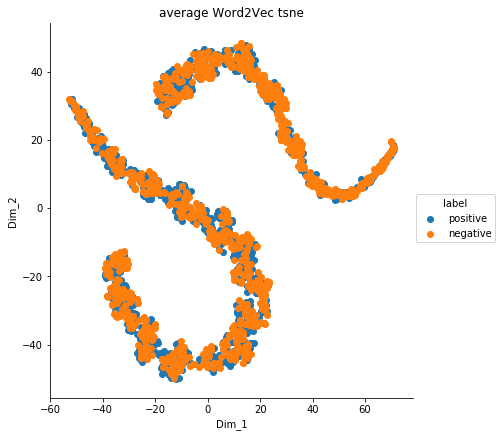

In [48]:

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T,SC)).T
tsne_df = pd.DataFrame(np.array(tsne_data), columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("average Word2Vec tsne")
plt.show()

In Above average Word2Vec tsne, positive and negative data points are overlapping, so unable to classify them

In [51]:
# TF-IDF weighted Word2Vec
#tfidf_feats = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 2000/2000 [00:03<00:00, 628.06it/s]


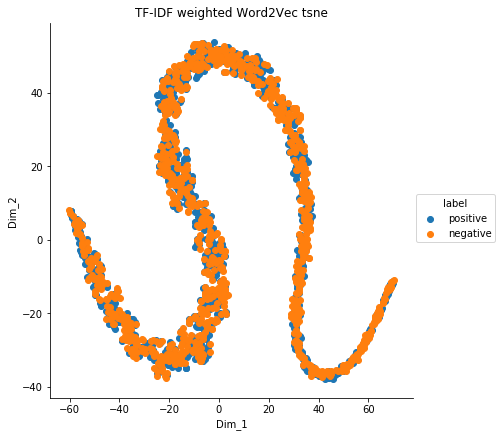

In [53]:
model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T,SC)).T
tsne_df = pd.DataFrame(np.array(tsne_data), columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TF-IDF weighted Word2Vec tsne")
plt.show()

In Above TF-IDF weighted Word2Vec tsne, positive and negative data points are overlapping, so unable to classify them

Observation :- In above all tsne plots, positive and negative datapoints are overlapping, so unable to classify them.